In [1]:
import argparse
import logging
import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from pathlib import Path

from utils.data_loading import BasicDataset
from unet import UNet
from utils.utils import plot_img_and_mask,concat_img_and_mask,add_mask_to_image
from utils.utils import apply_mask,random_colors
def predict_img(net,
                full_img,
                img_size,
                device,
                scale_factor=1,
                out_threshold=0.5):
    net.eval()
    if type(full_img)==np.ndarray:
        img = torch.from_numpy(BasicDataset.preprocess(full_img, scale_factor, is_mask=False,img_size=img_size))
    elif type(full_img)==torch.Tensor:
        img = full_img
    else:
        raise ValueError("Invalid image")

    img = img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)

        if net.n_classes > 1:
            probs = F.softmax(output, dim=1)[0]
        else:
            probs = torch.sigmoid(output)[0]

        tf = transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Resize((full_img.size[1], full_img.size[0])),
            transforms.ToTensor()
        ])

        full_mask = tf(probs.cpu()).squeeze()

    if net.n_classes == 1:
        return (full_mask > out_threshold).numpy()
    else:
        return F.one_hot(full_mask.argmax(dim=0), net.n_classes).permute(2, 0, 1).numpy()

def find_high_ligth(image,ligth_res=254):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray2 = img_gray > ligth_res
    return img_gray2.astype(np.int32)



def get_output_filenames(args):
    def _generate_name(fn):
        split = os.path.splitext(fn)
        return f'{split[0]}_OUT{split[1]}'

    return args.output or list(map(_generate_name, args.input))


def mask_to_image(mask: np.ndarray):
    if mask.ndim == 2:
        return Image.fromarray((mask * 255).astype(np.uint8))
    elif mask.ndim == 3:
        return Image.fromarray((np.argmax(mask, axis=0) * 255 / mask.shape[0]).astype(np.uint8))


In [25]:
import matplotlib.pyplot as plt
img_size=[512,512]
scale=0.5
mask_suffix ="_anno"
rm_hl =True
model = "./checkpoints/Cataract/checkpoint_epoch90.pth"

test_dir_img = Path("/path/WenJia/ZocEyeAI/YanQD/images/val/")
test_dir_mask = Path("/path/WenJia/ZocEyeAI/YanQD/annotations/val/Cataract/")

dataset = BasicDataset(test_dir_img, test_dir_mask, scale,mask_suffix,img_size)

net = UNet(n_channels=3, n_classes=2)

device = "cuda:1"


net.to(device=device)
net.load_state_dict(torch.load(model, map_location=device))

logging.info('Model loaded!')
colors = random_colors(10,False)



In [96]:
i=17
sample = dataset[i]
img,gt = sample["image"],sample["mask"]
img_w,img_h=img_size[0],img_size[1]
try:
    image = Image.open(os.path.join(test_dir_img,dataset.names[i]+".jpeg"))
    #image = cv2.imread(os.path.join(test_dir_img,dataset.names[i]+".jpeg"))
except:
    image = Image.open(os.path.join(test_dir_img,dataset.names[i]+".jpg"))
    #image = cv2.imread(os.path.join(test_dir_img,dataset.names[i]+".jpg"))

image = image.resize((int(img_w * scale),int(img_h * scale)))
#image = cv2.resize(image,(int(img_w * scale),int(img_h * scale)))
gt = gt.detach().numpy().astype(np.int32)
gt[gt>1] =1
mask = predict_img(net=net,
                   full_img=img,
                   img_size = img_size,
                   scale_factor=scale,
                   out_threshold=0.5,
                   device=device)
filename = dataset.names[i]
if  rm_hl:
    hl_image_seg = find_high_ligth(np.asarray(image).astype(np.uint8),254)
    hl_image_seg[hl_image_seg>1] = 1


In [98]:
colors = random_colors(5)
#colors=[(1,0,1),(1,0.5,0.7),(0,1,0.5)]
colors

[(0.0, 1.0, 0.40000000000000036),
 (1.0, 0.0, 0.0),
 (0.8000000000000007, 0.0, 1.0),
 (0.0, 0.40000000000000036, 1.0),
 (0.7999999999999998, 1.0, 0.0)]

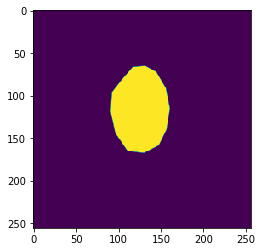

In [63]:
plt.imshow(gt)

In [101]:
result = mask_to_image(mask)
res = np.array(result).astype(np.int32)
res[res>1] =1
#result.save(out_filename)
#mutiplt_img = add_mask_to_image(image,result)
#mutiplt_img2 = add_mask_to_image(image,gt)

#out_filename1 = outdir +"/" + filename.split(".")[0]+"_pred1.png"
#concat_img_and_mask(image,result,out_filename1)
imm1 = apply_mask(np.asarray(image).astype(np.uint8),res.astype(np.int32),colors[1])
imm2 = apply_mask(np.asarray(image).astype(np.uint8),gt.astype(np.int32),colors[0])
if rm_hl:
    imm1 = apply_mask(imm1,hl_image_seg,colors[2])
    imm2 = apply_mask(imm2,hl_image_seg,colors[2])


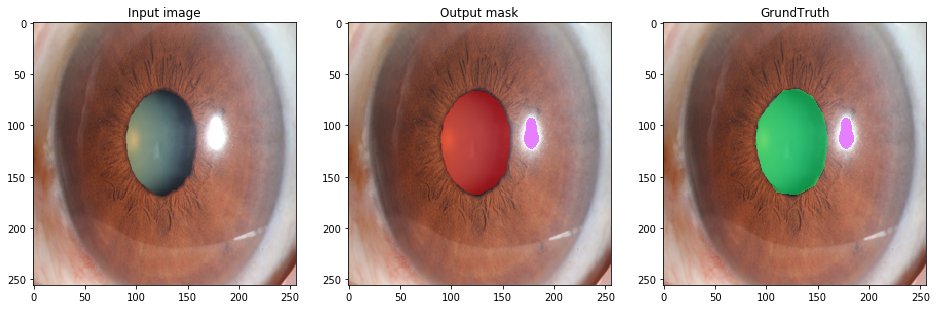

In [102]:
concat_img_and_mask(image,imm1,imm2,"test.png")

In [88]:
colors[1]

(0.0, 1.0, 1.0)